In [0]:
!pip install pysurvival

In [2]:
!curl -Lo m4.pkl https://manu00.s3-us-west-2.amazonaws.com/m4.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1313k  100 1313k    0     0   741k      0  0:00:01  0:00:01 --:--:--  741k


In [24]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.parametric import GompertzModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Reading the dataset
raw_dataset = pd.read_pickle("m4.pkl")

In [5]:
raw_dataset.columns

Index(['PolicyNumber', 'CoverageNumber', 'IssueAge', 'PolicyYear',
       'AttainedAge', 'IssueDate', 'MaturityDate', 'FaceAmount',
       'SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince',
       'COLAIndicator', 'benefitPeriod', 'benefitPeriod_grouped',
       'benefitExpiryDate', 'DisabilityDuration', 'disabilityAge',
       'DisabilityReason', 'productDesign', 'EliminationPeriod',
       'EliminationPeriod_grouped', 'policyStartDate', 'policyEndDate',
       'exposureStartDate', 'exposureEndDate', 'TerminationEvent',
       'terminationReason', 'train'],
      dtype='object')

In [0]:
raw_dataset.head()

,PolicyNumber,CoverageNumber,IssueAge,PolicyYear,AttainedAge,IssueDate,MaturityDate,FaceAmount,SmokerStatus,Gender,OccupationClass,CurrentProvince,COLAIndicator,benefitPeriod,benefitPeriod_grouped,benefitExpiryDate,DisabilityDuration,disabilityAge,DisabilityReason,productDesign,EliminationPeriod,EliminationPeriod_grouped,policyStartDate,policyEndDate,exposureStartDate,exposureEndDate,TerminationEvent,terminationReason,train
0,H 0826898,2,23,21,43,1990-05-08,2010-05-31,100.0,N,M,2A,NS,0,2 years,Short-Term,2012-04-14,6,56,Other cancer,IncomeReplacement,120,120+,2010-05-08,2011-05-07,2010-05-16,2010-06-15,1,Death,1
1,H 0828055,1,21,41,61,1976-10-15,2021-01-15,200.0,N,M,A,QC,0,2 years,Short-Term,2018-08-23,5,60,Other accident/poisonings,IncomeReplacement,7,00-30,2016-10-15,2017-10-14,2016-11-25,2016-12-24,0,None,0
2,H 0833653,1,35,30,64,1978-12-01,2009-04-01,200.0,N,M,3A,NS,0,To age 65,ToAge65,2009-03-29,5,63,Other genitourinary/reproductive disorders,IncomeReplacement,90,90,2007-12-01,2008-11-30,2008-05-26,2008-06-25,1,Other,1
3,H 0834890,1,30,30,59,1979-05-20,2014-08-20,725.0,N,M,2A,AB,0,5 years,Short-Term,2008-08-28,64,53,Other musculoskeletal disorders,IncomeReplacement,120,120+,2008-05-20,2009-05-19,2008-08-01,2008-08-31,0,None,1
4,H 0840908,1,28,33,60,1981-11-03,2018-05-03,500.0,N,M,A,QC,0,2 years,Short-Term,2015-10-16,4,60,Other musculoskeletal disorders,IncomeReplacement,30,00-30,2013-11-03,2014-11-02,2013-12-17,2014-01-16,1,Other,1


In [0]:
to_drop = ['PolicyNumber', 'IssueDate', 'MaturityDate', 'benefitExpiryDate', 'policyStartDate', 'policyEndDate',
           'exposureStartDate', 'exposureEndDate','terminationReason']
           
raw_dataset.drop(columns=to_drop,inplace=True)

categories = ['SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince','COLAIndicator', 'benefitPeriod',
              'benefitPeriod_grouped','DisabilityReason', 'productDesign', 'EliminationPeriod', 
              'EliminationPeriod_grouped']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)              

In [0]:
train_data = dataset[dataset.train==1]
pred_data = dataset[dataset.train==0]

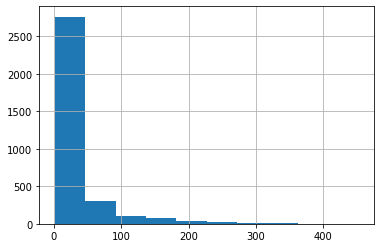

In [49]:
train_data['DisabilityDuration'].hist()

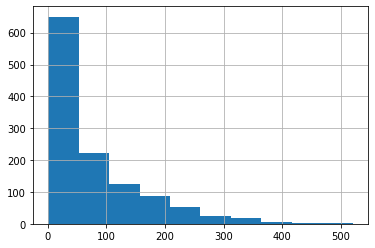

In [53]:
pred_data['DisabilityDuration'].hist()

In [8]:
train_data.drop(columns=['train'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
dataset.shape # (4539, 127)
train_data.shape #(3348, 127)

(3348, 111)

In [0]:
# Creating the time and event columns
time_column = 'DisabilityDuration'
event_column = 'TerminationEvent'

# Extracting the features
features = np.setdiff1d(train_data.columns, [time_column, event_column] ).tolist()

In [55]:
features

['AttainedAge',
 'COLAIndicator_1',
 'CoverageNumber',
 'CurrentProvince_BC',
 'CurrentProvince_MB',
 'CurrentProvince_NB',
 'CurrentProvince_NF',
 'CurrentProvince_NS',
 'CurrentProvince_ON',
 'CurrentProvince_Outside Canada',
 'CurrentProvince_PE',
 'CurrentProvince_QC',
 'CurrentProvince_SK',
 'CurrentProvince_YT',
 'DisabilityReason_Accidents/ poisoning/ violence',
 'DisabilityReason_Allergic/ endocrine/ metabolic/ nutritional',
 "DisabilityReason_Alzheimer's",
 'DisabilityReason_Aneurysm/cerebral vascular accident',
 'DisabilityReason_Arthritis',
 'DisabilityReason_Asthma',
 'DisabilityReason_Auto accident/MVA',
 'DisabilityReason_Bi-polar/manic',
 'DisabilityReason_Bowel cancer',
 'DisabilityReason_Breast cancer',
 'DisabilityReason_Carpal tunnel syndrome',
 'DisabilityReason_Chemical sensitivity/environmental illness',
 'DisabilityReason_Cholecystitis/gallstones',
 'DisabilityReason_Chronic obstructive pulmonary/lung disorders',
 'DisabilityReason_Chronic pain/fatigue syndrome',

In [0]:
interesting_fts = ['AttainedAge',
 'COLAIndicator_1',
 'CoverageNumber',
 'EliminationPeriod_120',
 'EliminationPeriod_14',
 'EliminationPeriod_15',
 'EliminationPeriod_180',
 'EliminationPeriod_30',
 'EliminationPeriod_365',
 'EliminationPeriod_60',
 'EliminationPeriod_7',
 'EliminationPeriod_730',
 'EliminationPeriod_90',
 'EliminationPeriod_grouped_120+',
 'EliminationPeriod_grouped_60',
 'EliminationPeriod_grouped_90',
 'FaceAmount',
 'Gender_M',
 'IssueAge',
 'OccupationClass_3A',
 'OccupationClass_4A',
 'OccupationClass_4S',
 'OccupationClass_A',
 'OccupationClass_B',
 'PolicyYear',
 'SmokerStatus_S',
 'benefitPeriod_Lifetime/To age 101',
 'benefitPeriod_To age 65',
 'benefitPeriod_grouped_Short-Term',
 'benefitPeriod_grouped_ToAge65',
 'disabilityAge',
 'productDesign_IncomeReplacement',
 'productDesign_Proguard']

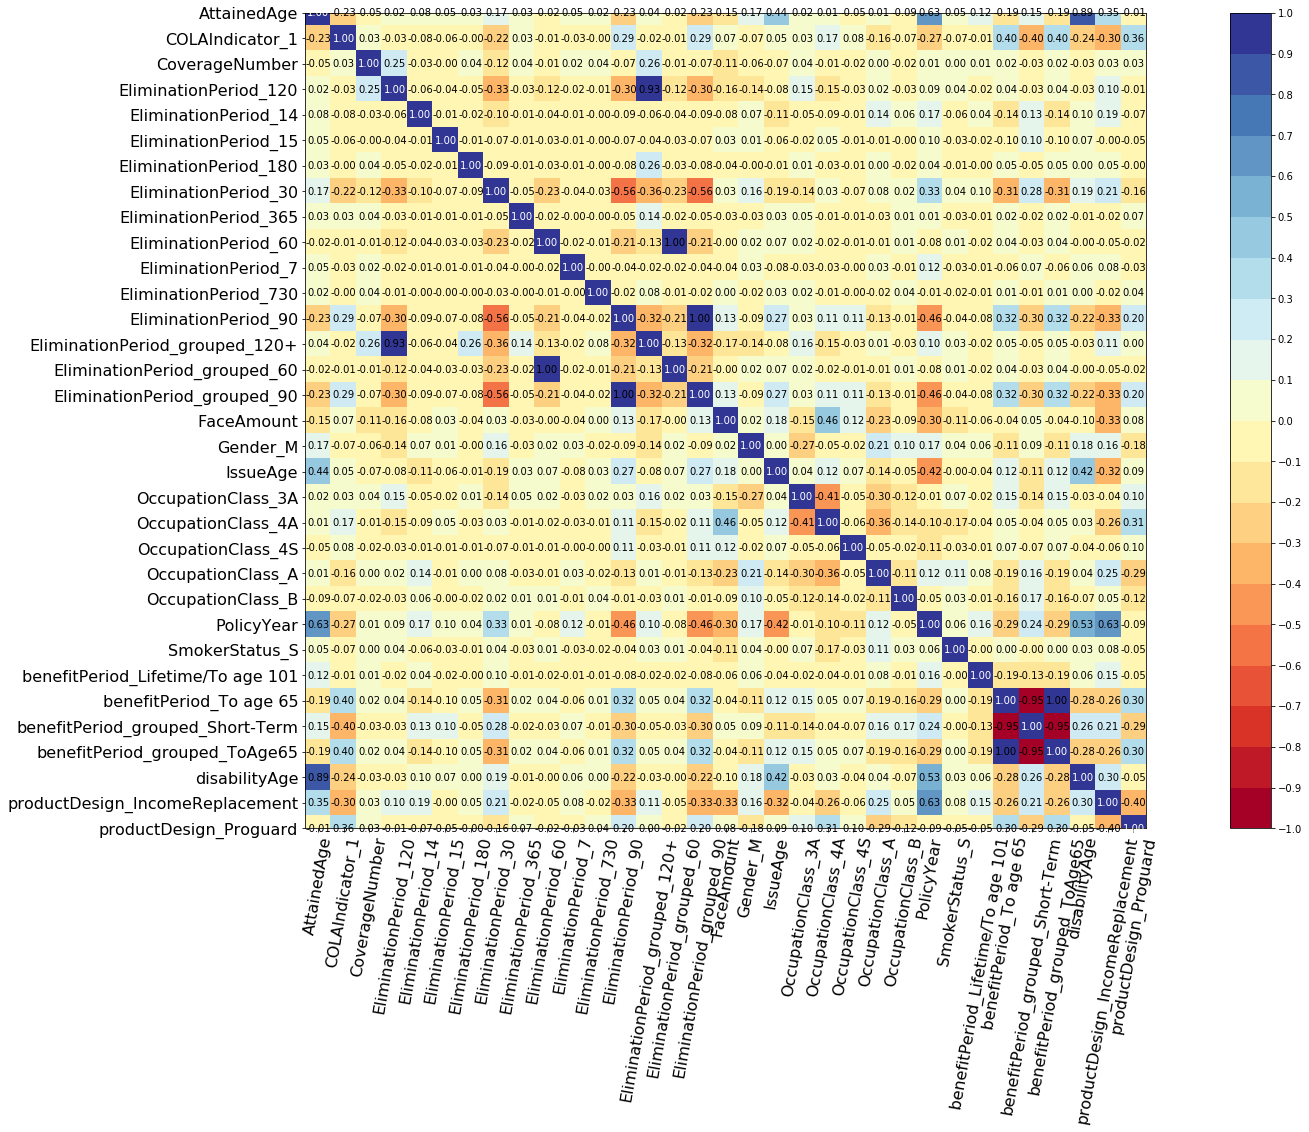

In [59]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(train_data[interesting_fts], figure_size=(30,15), text_fontsize=10)

In [11]:
%%time
# Checking for null values
N_null = sum(train_data[features].isnull().sum())
print("The train_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(train_data.duplicated(keep='first'))
train_data = train_data.drop_duplicates(keep='first').reset_index(drop=True)
print("The train_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = train_data.shape[0]

The train_dataset contains 0 null values
The train_dataset contains 1 duplicates
CPU times: user 56 ms, sys: 4.28 ms, total: 60.3 ms
Wall time: 67.2 ms


In [12]:
train_data.shape

(3347, 111)

In [0]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.3)
data_train = train_data.loc[index_train].reset_index( drop = True )
data_test  = train_data.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [15]:
#Standard CoxPH
%%time
from pysurvival.models.semi_parametric import CoxPHModel
coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.5, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 12415.702 - ||grad||^2 = 1552.80064
 * Iteration #2 - Loss = 11908.353 - ||grad||^2 = 842.37353
 * Iteration #3 - Loss = 11619.959 - ||grad||^2 = 520.08988
 * Iteration #4 - Loss = 11401.345 - ||grad||^2 = 336.83425
 * Iteration #5 - Loss = 11274.455 - ||grad||^2 = 217.78986
 * Iteration #6 - Loss = 11218.504 - ||grad||^2 = 131.41075
 * Iteration #7 - Loss = 11195.782 - ||grad||^2 = 74.84622
 * Iteration #8 - Loss = 11187.440 - ||grad||^2 = 40.84653
 * Iteration #9 - Loss = 11184.675 - ||grad||^2 = 21.61550
 * Iteration #10 - Loss = 11183.819 - ||grad||^2 = 11.22051
 * Iteration #11 - Loss = 11183.555 - ||grad||^2 = 5.77038
 * Iteration #12 - Loss = 11183.468 - ||grad||^2 = 2.96212
 * Iteration #13 - Loss = 11183.435 - ||grad||^2 = 1.52623
 * Iteration #14 - Loss = 11183.419 - ||grad||^2 = 0.79279
 * Iteration #15 - Loss = 11183.412 - ||grad||^2 = 0.41670
 * Iteration #16 - Loss = 11183.407 - ||grad||^2 = 0.22230
 * Iterat

/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


C-index: 0.81


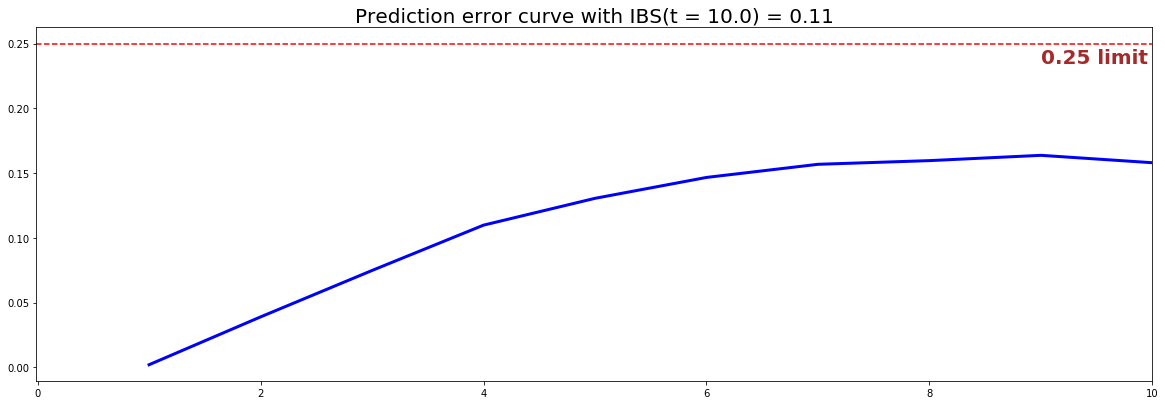

IBS: 0.11


In [25]:
#Cross Validation / Model Performances
c_index = concordance_index(coxph, X_test, T_test, E_test) #0.92
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(coxph, X_test, T_test, E_test, t_max=10,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

C-index: 0.85


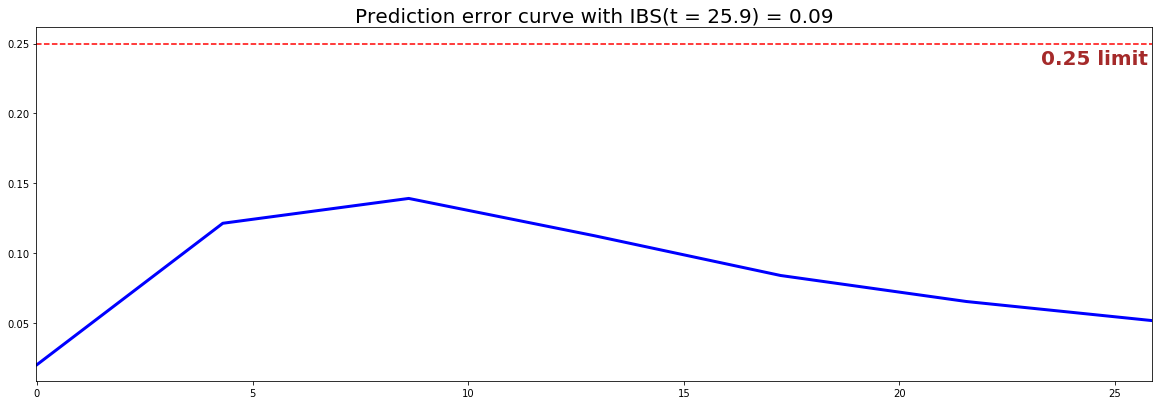

IBS: 0.09
CPU times: user 3.25 s, sys: 189 ms, total: 3.44 s
Wall time: 3.51 s


In [30]:
%%time
##5 -- best so far
from pysurvival.models.parametric import GompertzModel #try other models
# Building the model
gomp_model = GompertzModel()
gomp_model.fit(X_train, T_train, E_train, lr=1e-2, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-3, num_epochs=1500)


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(gomp_model, X_test, T_test, E_test) #0.77
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(gomp_model, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

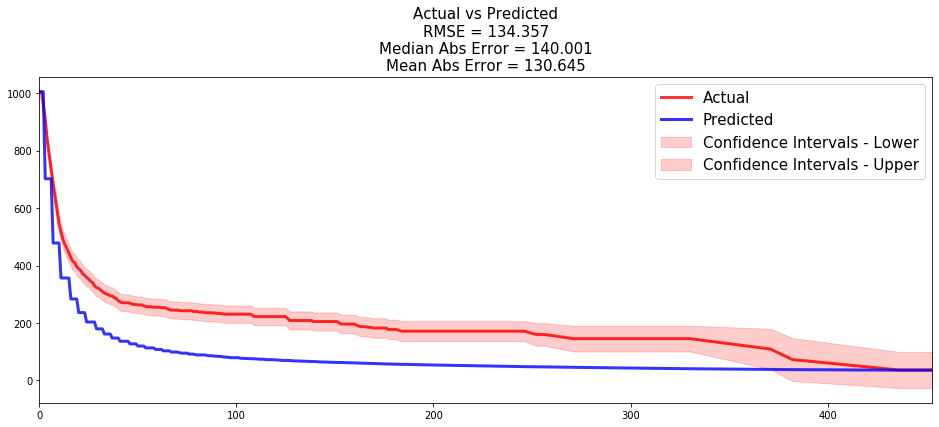

In [41]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(gomp_model, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

In [56]:
%%time
##6
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

CPU times: user 5min, sys: 489 ms, total: 5min
Wall time: 2min 32s


In [60]:
# Computing variables importance
csf.variable_importance_table.head(20)

,feature,importance,pct_importance
0,AttainedAge,9.998489,0.124875
1,PolicyYear,6.750890,0.084314
2,IssueAge,5.623592,0.070235
3,EliminationPeriod_grouped_120+,5.535432,0.069134
4,productDesign_IncomeReplacement,4.905520,0.061267
5,productDesign_Venture_Total,4.022191,0.050235
6,EliminationPeriod_120,3.897587,0.048678
7,disabilityAge,3.304914,0.041276
8,benefitPeriod_2 years,2.857574,0.035689
9,OccupationClass_3A,2.720784,0.033981


In [61]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.83

C-index: 0.67
